In [7]:
from itertools import combinations
import os

from keras._tf_keras.keras.callbacks import EarlyStopping 
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import schedules, SGD 
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout
from keras._tf_keras.keras.regularizers import l2
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer

In [8]:

def normalize_landmark_locations(df : pd.DataFrame, landmark_cols):
    """
    Normalizes landmark locations in a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing landmark data.
        landmark_cols (list): A list of column names representing landmark coordinates.

    Returns:
        pd.DataFrame: The modified DataFrame with normalized landmark columns.

    Raises:
        ValueError: If any column in landmark_cols is not present in the DataFrame.
    """

    for col in landmark_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

        # Calculate mean and standard deviation for the current landmark column
        mean_col = df[col].mean()
        std_col = df[col].std()

        # Update the existing column with normalized values
        df[col] = (df[col] - mean_col) / std_col

    return df

def calculate_landmark_angles(df: pd.DataFrame, landmark_cols):
  """
  Calculates overall gesture angles for each landmark combination.

  Args:
      df (pd.DataFrame): DataFrame containing landmark data.
      landmark_cols (list): List of column names representing landmark coordinates.

  Returns:
      pd.DataFrame: DataFrame containing a single column for each landmark combination angle (average, min, or max).
  """

  angles = {}
  for i in range(len(landmark_cols) - 2):
    col1, col2, col3 = landmark_cols[i], landmark_cols[i+1], landmark_cols[i+2]
    angle_col = f"angle_{col1}_{col2}_{col3}"

    # Compute vectors between landmarks (same as before)
    vec1 = df[[f'x_{col2[2:]}', f'y_{col2[2:]}', f'z_{col2[2:]}']].values - df[[f'x_{col1[2:]}', f'y_{col1[2:]}', f'z_{col1[2:]}']].values
    vec2 = df[[f'x_{col3[2:]}', f'y_{col3[2:]}', f'z_{col3[2:]}']].values - df[[f'x_{col2[2:]}', f'y_{col2[2:]}', f'z_{col2[2:]}']].values

    # Calculate dot product and magnitudes (same as before)
    dot_product = np.sum(vec1 * vec2, axis=1)
    magnitude1 = np.linalg.norm(vec1, axis=1)
    magnitude2 = np.linalg.norm(vec2, axis=1)

    # Avoid division by zero or very small values (same as before)
    mask = (magnitude1 * magnitude2) != 0
    dot_product[mask] /= (magnitude1[mask] * magnitude2[mask])

    # Clip values to prevent invalid input to arccos (same as before)
    dot_product = np.clip(dot_product, -1.0, 1.0)

    # Compute angle between vectors
    angles[angle_col] = np.arccos(dot_product) * (180 / np.pi)

  # Calculate representative angle (choose one option)
  representative_angles = {}
  for angle_col, angle_values in angles.items():
    # Option 1: Average Angle
    representative_angles[angle_col] = np.mean(angle_values)

    # Option 2: Minimum Angle
    # representative_angles[angle_col] = np.min(angle_values)

    # Option 3: Maximum Angle
    # representative_angles[angle_col] = np.max(angle_values)

  return pd.DataFrame(representative_angles)

def calculate_hand_motion_features(df, landmark_cols):
    """
    Feature engineers these new features: 
        - normalized landmarks locations  ✅
        - velocity (temporal feature) ✅
        - acceleration (temporal feature) ✅
        - relative pairwise distances (Euclidean distance) ✅
        - relative landmark angles


        IMPORTANT QUOTE?: Feature engineering should focus on extracting features from the entire sequence rather than indivudally

    """
    df_copy = df.copy()
    new_cols = {}

    for col in landmark_cols:
        new_cols[f"velocity_{col}"] = df[col].diff().fillna(0)
        new_cols[f"acceleration_{col}"] = new_cols[f"velocity_{col}"].diff().fillna(0)

    # Calculate pairwise distancces between all landmarks 
    landmark_pairs = list(combinations(landmark_cols, 2))
    for (col1, col2) in landmark_pairs:
        idx1 = col1[1:]
        idx2 = col2[1:]

        if idx1 == idx2:
            continue
        x1, y1, z1 = f'x{idx1}', f'y{idx1}', f'z{idx1}'
        x2, y2, z2 = f'x{idx2}', f'y{idx2}', f'z{idx2}'
        distance_col = f'distance_{idx1}_{idx2}'
        new_cols[distance_col] = np.sqrt((df[x1] - df[x2])**2 + (df[y1] - df[y2])**2 + (df[z1] - df[z2])**2)
    
    # Normalized Landmark locations
    # Can do this in the pipeline if needs be
    normalized_df = normalize_landmark_locations(df_copy, landmark_cols)
    new_cols.update(normalized_df.filter(regex="norm").to_dict())

    # # Relative Landmark angles
    # angle_df  = calculate_landmark_angles(df_copy, landmark_cols)
    # new_cols.update(angle_df.to_dict())

    new_df = pd.DataFrame(new_cols)
    return pd.concat([df, new_df], axis=1)


def create_dataframe_from_data(input_path):
    """
    Takes in the multiple CSV files from the input_path and creates 1 dataframe out of them.

    returns: Dataframe
    """

    data_frames = [] 
    landmark_cols = []
    landmark_world_cols = []
    gesture_index = 0 

    for file_name in os.listdir(input_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_path, file_name)

            dataframe = pd.read_csv(file_path)

            # Gathers the landmark column hands (once)
            if(len(landmark_cols) == 0 and len(landmark_world_cols) == 0):
                landmark_cols = [col for col in dataframe.columns if col.startswith(("x", "y", "z"))]
                landmark_world_cols = [col for col in dataframe.columns if col.startswith(("wx", "wy", "wz"))]
            
            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])

            dataframe["gesture"] = gesture
            dataframe["gesture_index"] = gesture_index

            dataframe.sort_values(by="frame", inplace=True)

            data_frames.append(dataframe)

    if len(data_frames) == 0:
        raise ValueError("Dataframe has no data")
    else:
        return pd.concat(data_frames, ignore_index=True), landmark_cols, landmark_world_cols
    
def reshape_for_lstm(X, time_steps=30):
    n_samples = len(X) // time_steps
    X = X.iloc[:n_samples * time_steps, :]  # Ensure even division
    return X.values.reshape(n_samples, time_steps, -1)

c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 2, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 8)              │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,718 (22.34 KB)

 Trainable params: 5,718 (22.34 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2243 - loss: 1.8093 - val_accuracy: 0.0000e+00 - val_loss: 1.8114
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4127 - loss: 1.7888 - val_accuracy: 0.0000e+00 - val_loss: 1.8072
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4727 - loss: 1.7683 - val_accuracy: 0.0000e+00 - val_loss: 1.8034
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4697 - loss: 1.7508 - val_accuracy: 0.0000e+00 - val_loss: 1.8000
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4729 - loss: 1.7326 - val_accuracy: 0.0000e+00 - val_loss: 1.7969
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4669 - loss: 1.7159 - val_accuracy: 0.0000e+00 - val_loss: 1.7941
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4787 - loss: 1.6983 - val_accuracy: 0.0000e+00 - val_loss: 1.7917
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4720 

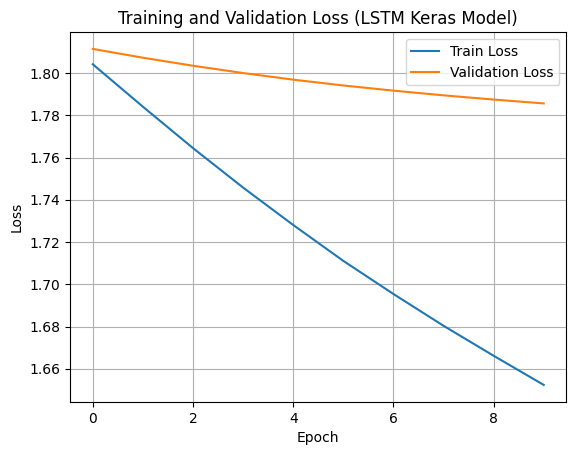

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [9]:

def main():
    input_dir = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\data"
    dataframe, landmark_cols, landmark_world_cols = create_dataframe_from_data(input_dir)

    # dataframe.to_csv('model/LSTM/df_combined.csv')

    X = dataframe.drop(columns=['gesture'], axis=1)
    y = dataframe['gesture']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False, random_state=42)
    X_train, X_val, y_train , y_val = train_test_split(X_train, y_train, test_size=.25, shuffle=False, random_state=42)

    # print_shapes(X_train, X_test, y_train, y_test, X_val, y_val)

    X_train = calculate_hand_motion_features(X_train, landmark_cols)
    X_val = calculate_hand_motion_features(X_val, landmark_cols) # problem with the x_val and X_test, size changes
    X_test = calculate_hand_motion_features(X_test, landmark_cols)

    # print_shapes(X_train, X_test, y_train, y_test, X_val, y_val)

    # Ensure shapes are consistent
    assert (X_train.shape[0] == y_train.shape[0]) and  (X_test.shape[0] == y_test.shape[0]) and (X_val.shape[0] == y_val.shape[0]), "Shapes of X_train, X_val, and X_test are not consistent."


    numerical_transformer = Pipeline(steps= [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('scaler2', MinMaxScaler()),
        ('pca', PCA(n_components=2))
    ])

    X_train_transformed = numerical_transformer.fit_transform(X_train)
    X_val_transformed = numerical_transformer.transform(X_val)
    X_test_transformed = numerical_transformer.transform(X_test)

    label_encoder = LabelEncoder()
    combined_labels = pd.concat([y_train, y_val, y_test])
    label_encoder.fit(combined_labels)

    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    # print_shapes(X_train_transformed, X_test_transformed, y_train_encoded, y_test_encoded, X_val_transformed, y_val_encoded)
    
    # Reshape X_train_transformed, X_val_transformed, X_test_transformed for LSTM input
    X_train_reshaped = X_train_transformed.reshape((X_train_transformed.shape[0], X_train_transformed.shape[1], 1))
    X_val_reshaped = X_val_transformed.reshape((X_val_transformed.shape[0], X_val_transformed.shape[1], 1))
    X_test_reshaped = X_test_transformed.reshape((X_test_transformed.shape[0], X_test_transformed.shape[1], 1))

    # print_shapes(X_train_reshaped, X_test_reshaped, y_train_encoded, y_test_encoded, X_val_reshaped, y_val_encoded)


    # Define LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(X_train_transformed.shape[1], 1), return_sequences=True, kernel_regularizer=l2()))
    model.add(Dropout(0.2))
    model.add(LSTM(units=8, return_sequences=False)),  # Optional additional LSTM layer
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))
    
    init_learning_rate = 0.0005
    decay_steps = 1000
    decary_rate = 0.95 

    learning_rate_schedule = schedules.ExponentialDecay(
        initial_learning_rate=init_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decary_rate,
        staircase=True
    )
    optimizier = SGD(learning_rate=learning_rate_schedule)
    # Compile the model
    model.compile(optimizer=optimizier, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(
        X_train_reshaped, y_train_encoded, 
        epochs=10, 
        batch_size=32,
        validation_data=(X_val_reshaped, y_val_encoded), 
        callbacks=[early_stopping])

    # Evaluate the model on test set
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded)
    print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')


    # Extracting the history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    epochs = range(len(train_loss))  # Assuming loss recorded for each epoch

    # Plotting
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss (LSTM Keras Model)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Make predictions
    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)



def create_sequences(data, labels, timesteps):
    sequences = [] 
    sequence_labels = [] 

    for i in range(len(data) - timesteps):
        sequences.append(data[i:i +timesteps])
        sequence_labels.append(labels[i + timesteps])

    return np.array(sequences), np.array(sequence_labels)

def print_shapes(X_train, X_test, y_train, y_test, X_val, y_val):
    print(X_train.shape)
    print(X_val.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)
    print()

main()